# Erdos-Renyi Model
### Using the Erdos-Renyi model, find the graph of probability that all nodes in a random graph are connected, against probability $p$, for different values of $n$. Then, find an expression for the threshold probability of the graph as a function of $n$.

The first part of the code defines a function to trial and output the probability of all nodes in a random graph being connected, for a fixed $n$ and $p$. This here is the function, and an example of its usage.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# function meant to calculate the proportion of connected graphs for a given n and p
def test(n, p, num):   
    count = 0
    for i in range(num):
        g = nx.erdos_renyi_graph(n, p)
        if nx.is_connected(g):
            count +=1
    percentage = (count/num)
    return percentage

# Example of running test() function
n, p, num = 100, 0.05, 100   
res = test(n, p, num)

print(f"Number of nodes: {n}\nProbability: {p}\nProbability of all being connected: {res}")

Number of nodes: 100
Probability: 0.05
Probability of all being connected: 0.54


Next, we extend this function to trial for different values of $p$, and collect the data, thus constructing such a graph for a fixed value of $n$. Below is just an example.

In [46]:
# Collecting data for different values of p for a given n, using the "graph" dictionary
graph = {}   
for p in np.arange(0, 0.3, 0.01):
    res = test(n, p, 10)
    graph[p] = res

Now with the data for different values of p, we have to expand this by implementing different values of $n$. At the same time, we want to find out the threshold probability for each value of $n$ used. We will define the $threshold$ as the probability at which the gradient of the graph is the sharpest.
The $threshold$ is found by using the numpy gradient function on the list of values calculated.

In [2]:
thresholds = {} 

# Collecting data for 10<n<100
for nodes in range(10, 101, 1): 
    graph = {}
    for i in np.arange(0, 1, 0.001): # Varying p for 0 < p < 0.8
        res = test(nodes, i, 1000)
        graph[i] = res
        if res == 1:  # When all 1000 of 1000 graphs are connected, the loop is broken to save time
            break
    plt.title(f"Erdos-Renyi: n = {nodes}")    # Plotting the graphs and saving them
    plt.xlabel("p")
    plt.ylabel("Probability of all nodes being connected")
    plt.plot(graph.keys(), graph.values())
    plt.axis([0, 1, 0, 1])
    plt.savefig(f'ER{nodes}')
    data = np.array(list(graph.values()))
    
    # Collecting the values of the thresholds in dictionary "thresholds"
    for p in range(np.size(data)):   
        if np.gradient(data)[p] == max(np.gradient(data)):
            thresholds[nodes] = list(graph.keys())[p]   
    plt.clf()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\kjkchang\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-c674a78f3ac3>", line 7, in <module>
    res = test(nodes, i, 1000)
  File "<ipython-input-1-8b82f48733fe>", line 10, in test
    if nx.is_connected(g):
  File "<decorator-gen-299>", line 2, in is_connected
  File "C:\Users\kjkchang\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\utils\decorators.py", line 82, in _not_implemented_for
    return not_implement_for_func(*args, **kwargs)
  File "C:\Users\kjkchang\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\algorithms\components\connected.py", line 162, in is_connected
    return sum(1 for node in _plain_bfs(G, arbitrary_element(G))) == len(G)
  File "C:\Users\kjkchang\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\algorithms\components\connected.py", l

KeyboardInterrupt: 

In [ ]:
import time

toc = time.time()
def trial(n, p):
    g = nx.erdos_renyi_graph(n, p)
    return nx.is_connected(g)

trial = np.vectorize(trial)
res = {}
def mass_trial(n, p, num):
    res[p] = sum(trial(np.full(num, n), np.full(num, p))) / num
    return res

mass_trial = np.vectorize(mass_trial)
num = 1000
thresholds = {}

for n in range(10, 101):
    res = {}
    mass_trial(np.full(800, n), np.arange(0.01, 0.81, 0.001), np.full(800, num))
    plt.plot(res.keys(), res.values())
    plt.title(f"Erdos-Renyi: n = {n}")
    plt.xlabel("p")
    plt.ylabel("Probability of all nodes being connected")
    plt.axis([0, 1, 0, 1])
    plt.plot(res.keys(), res.values())
    plt.savefig(f'ER{n}')
    data = np.array(list(res.values()))
    thresholds[n] = np.max(np.gradient(data))
    print(n)

tic = time.time()
print(f"Time taken: {tic-toc}")

After plotting graphs for $n$ where $10<n<100$, we can now determine the shape of the graph. Which is weird.
From the graphs, we have also found the threshold values for the values of $n$, thus we can plot that onto a graph and attempt to map a function to it.

In [ ]:
plt.title("Thresholds against number of nodes")
plt.xlabel("Number of nodes")
plt.ylabel("Threshold probabillity")
plt.plot(thresholds.keys(), thresholds.values())
plt.axis([0, 100, 0, 0.3])
plt.savefig('Thresholds')

Given the graph for thresholds against number of nodes, it should be noted that the graph is more inconsistent when the number of nodes are fewer. 
To try and model the threshold using a function, we will assume a power law whereby $t = an^b$, where both $a$ and $b$ are constants. Thus we take log to base 10 on both sides, and perform linear regression on $log_{10} t$ and $log_{10} n$.

The coefficient and vertical intercept are then found, which are equal to $b$, and $log_{10} a$ respectively.

In [51]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
y = np.array(list(map(np.math.log10, thresholds.values()))).reshape(-1, 1)
x = np.array(list(map(np.math.log10,[key for key in thresholds.keys()]))).reshape(-1,1)
reg.fit(x, y)
print(f"b = {reg.coef_}")
print(f"log10a = {reg.intercept_}")

b = [[-0.75009541]]
log10a = [0.17443774]


With the values of the coefficient and intercept, we shall now plot another graph using our power law to compare the model with the data collected.

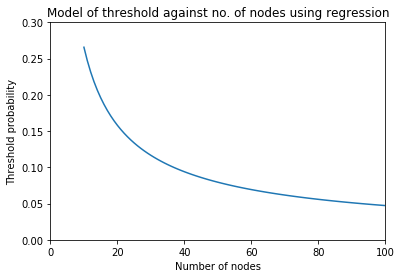

In [52]:
t_x = [i for i in range(10, 101)]
t_y = [((i**reg.coef_[0][0])*(10**reg.intercept_[0])) for i in t_x]
plt.title("Model of threshold against no. of nodes using regression")
plt.xlabel("Number of nodes")
plt.ylabel("Threshold probability")
plt.plot(t_x, t_y)
plt.axis([0, 100, 0, 0.3])
plt.show()

Thus from running the program, we find our expression of $t$ to be $t = 1.569n^{-0.760}$. 